## Goal: Differentiate Infections, sterile inflammation, and healthy tissue using MRI
The following methods were used in this study:
1. T2 relaxation of the tissue without a contrast agent
2. Dynamic contrast-enhanced (DCE) MRI using Maltose as a T2-ex contrast agent
3. Chemical Exchange Saturation Transfer (CEST) MRI without a contrast agent

**Author**: Julio Cárdenas-Rodríguez, Ph.D.  
**email**:  cardenaj@email.arizona.edu

### Description of the data
A total of **XX** mice were used in this study. Each mouse was infected as follows:
- Right thigh: with approximatley 100 uL of a solution of XX CFU/mL of *E. Coli*.
- Left thigh: same dose but using a solution that contain heat-inactivated *E. Coli*.

Both thighs can be seen in each image, and a total of of five imaging slices were collected around the center of infection. The average signal for the following region of interest (ROIS) were collected for all slices:

1. Infected Site
2. Apparently Healthy Tissue on the right thigh
3. Sterile inflammation on the left thigh
4. Apparently Healthy Tissue on the left thigh

In [233]:
# Import Python Modules
import numpy as np
#import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
import pandas as pd
# Import LOCAL functions written by me
from mylocal_functions import * 

## T2 relaxation

In [2]:
# Make list of all T2.txt files
T2_list = get_ipython().getoutput('ls ../Study_03_CBA/*T2.txt')

# Allocate variables needed for analysis
T2DF=pd.DataFrame()
TR=np.linspace(.012,.012*12,12)

# Fit T2 for all ROIs, slices and mice. construct dataframe
for names in T2_list:
    #Convert txt file to array
    YDataMatrix=txt_2_array(names)
    #Estimate T2
    T2time=fitT2(TR,YDataMatrix)
    #convert to data frame
    df_T2=pd.DataFrame(T2time.T,columns=["Infected","Healthy_Right","Sterile_Inflammation","Healthy_Left"])
    #df_T2=pd.DataFrame(T2time.T,columns=["ROI-1","ROI-2","ROI-3","ROI-4"])
    df_info=name_2_df(names)
    df_final=pd.concat([df_T2,df_info], axis=1)
    T2DF=T2DF.append(df_final,ignore_index=True)

(0.025, 0.15)

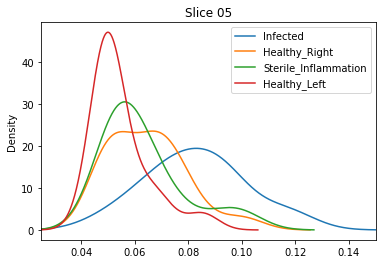

In [3]:
# Plot distribution of estimated T2 for each slice
#T2DF[T2DF.Slice==1].iloc[:,:4].plot.density(); title("Slice 01"); xlim((0.025,.15))
#T2DF[T2DF.Slice==2].iloc[:,:4].plot.density(); title("Slice 02"); xlim((0.025,.15))
#T2DF[T2DF.Slice==3].iloc[:,:4].plot.density(); title("Slice 03"); xlim((0.025,.15))
#T2DF[T2DF.Slice==4].iloc[:,:4].plot.density(); title("Slice 04"); xlim((0.025,.15))
T2DF[T2DF.Slice==5].iloc[:,:4].plot.density(); title("Slice 05"); xlim((0.025,.15))

# Fit CEST for each slices and mouse

In [113]:
# list of files
CEST_list=get_ipython().getoutput('ls ../Study_03_CBA/*CEST.txt')
CEST_DF=pd.DataFrame()
Z=np.zeros((4,110))

def normalize_data(DataMatrix):
    rows,cols = DataMatrix.shape
    newData = np.zeros_like(DataMatrix)
    for row in range(rows):
        newData[row,:]=DataMatrix[row,:]/DataMatrix[row,8]      
    return newData

for names in CEST_list:
    #Convert txt file to array
    D=txt_2_array(names); 
    Zn=normalize_data(D.T)
    Z=np.concatenate((Z,Zn))

Z=Z[4::,9::]
    
# define offsets in ppm
a1=np.linspace(-55,-50,9)
ppm=np.linspace(-8,8,101)
full_ppm = np.concatenate((a1, ppm))

[ 0.63021089  3.46189776  0.1         0.07612609  3.7466548  -4.25346642
  0.08767454]


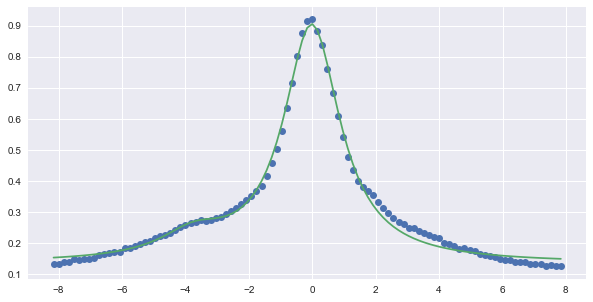

In [223]:
# Fit data
from scipy.optimize import curve_fit 
import seaborn as sn
from mylocal_functions import *

def Lorentzian(sat_offset,Amp,Width,Center):
    Width = Width**2; Width=Width/4 
    xdata = (sat_offset-Center)**2
    return (Amp*Width) / (Width +xdata )

def Lorentzian2(sat_offset,a1,w1,c1,a2,w2,c2):
    return Lorentzian(sat_offset,a1,w1,c1) + Lorentzian(sat_offset,a2,w2,c2)


#
Signal=1-Z[12,:]
# fix xdata
xdata=ppm-ppm[Signal.argmax()]
# allocate fitting based on this 
A10, W10, C10 =  0.90, 1, 0
A20, W20, C20 =  .1, 1, -4

A1L, W1L, C1L =  0.5, .1, -.1
A2L, W2L, C2L =  0, .1,   -6

A1U, W1U, C1U =  1.0, 5, +.1
A2U, W2U, C2U =  1.0, 5, -1.0

scale0, scaleL, scaleU = 0, -1, +1

initial_guess = [A10, W10, C10,      A20, W20, C20,    scale0]
lb            = [A1L, W1L, C1L,      A2L, W2L, C2L,    scaleL]
ub            = [A1U, W1U, C1U,      A2U, W2U, C2U,    scaleU]

p, cov = curve_fit(Lscale, xdata, Signal,p0=initial_guess,bounds=(lb, ub))
print(pars_hat)

Yhat=Lscale(xdata,p[0],p[1],p[2],p[3],p[4],p[5],p[6]);
plt.figure(figsize=(10,5))
plt.plot(xdata,Signal,'o',label='Signal'); 
plt.plot(xdata,Yhat,'-',label='Signal'); 


In [232]:
from mylocal_functions import *
mylocal_functions.fit_L2_scale?

Object `mylocal_functions.fit_L2_scale` not found.


(2, 1, 7)

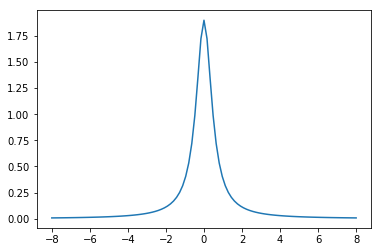

In [193]:
plt.plot(ppm,Lscale(ppm,A10, W10, C10,      A20, W20, C20,    scale0));

initial_guess = [A10, W10, C10,      A20, W20, C20,    scale0];
lb            = [A1L, W1L, C1L,      A2L, W2L, C2L,    scaleL];
ub            = [A1U, W1U, C1U,      A2U, W2U, C2U,    scaleU];



A=[[initial_guess],[initial_guess]]
array(A).shape


In [147]:
ppm[Signal.argmax()]

4.8000000000000007

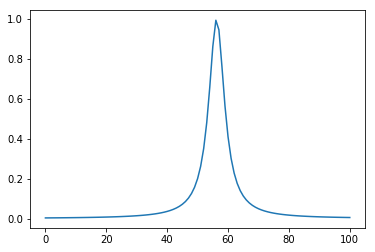

In [131]:
L=  Lorentzian(ppm,1,1,1); plt.plot(L)

(-10, 10)

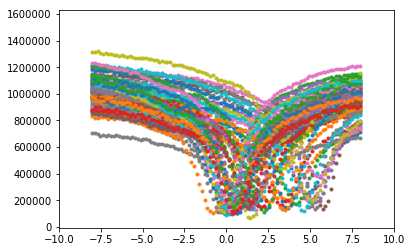

In [64]:
plt.plot(ppm,Z.T,'.'); plt.xlim(-10,10)

In [68]:
len(CEST_list)

16

In [52]:
Z=np.zeros?

In [ ]:
Z=np.zeros

(-10, 10)

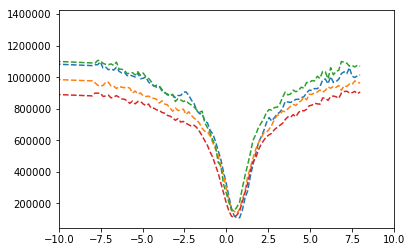

In [45]:
plt.plot(ppm,Z,'--'); plt.xlim(-10,10)

In [ ]:
    #Estimate T2
    T2time=fitT2(TR,YDataMatrix)
    #convert to data frame
    df_T2=pd.DataFrame(T2time.T,columns=["Infected","Healthy_Right","Sterile_Inflammation","Healthy_Left"])
    #df_T2=pd.DataFrame(T2time.T,columns=["ROI-1","ROI-2","ROI-3","ROI-4"])
    df_info=name_2_df(names)
    df_final=pd.concat([df_T2,df_info], axis=1)
    T2DF=T2DF.append(df_final,ignore_index=True)

In [18]:
df_info=name_2_df(names)
df_info

,Month,Year,Mouse,Day,Slice
0,1,2017,M5,6,5


In [16]:
# Make list of all T2.txt files
CEST_list=get_ipython().getoutput('ls ../Study_03_CBA/*T2.txt')
for names in CEST_list:
    Ydata=txt_2_array(names)
    print(Ydata)
    df_info=name_2_df(names)

[[ 367892.  263009.  270195.  281861.]
 [ 328246.  201351.  216117.  226610.]
 [ 260527.  114746.  131092.  135326.]
 [ 222104.   91496.  106150.  106749.]
 [ 187868.   56680.   68406.   68951.]
 [ 173426.   45618.   53132.   55005.]
 [ 152167.   25581.   39944.   35087.]
 [ 133992.   25784.   31413.   31932.]
 [ 128603.   15702.   22174.   21866.]
 [ 115221.   14972.   20877.   20103.]
 [ 106364.   13531.   17704.   15271.]
 [  99744.   12820.   16177.   16793.]]
[[ 279800.  224995.  310532.  252678.]
 [ 245980.  163601.  260770.  195819.]
 [ 171551.  106592.  188392.  116671.]
 [ 146527.   89846.  164779.   86285.]
 [ 111523.   56815.  128779.   60903.]
 [ 100048.   44426.  111997.   48461.]
 [  82280.   37343.   93223.   33210.]
 [  73195.   32105.   84228.   23461.]
 [  66633.   15695.   70225.   23409.]
 [  59873.   22108.   67233.   18125.]
 [  54866.   19055.   58278.   10978.]
 [  51036.   13813.   57394.   19180.]]
[[ 307117.  256895.  267627.  280365.]
 [ 256060.  196916.  20

In [7]:
def scale(y,index):
    return y/y[index
    
for names in CEST_list:
               print(names)

SyntaxError: invalid syntax (<ipython-input-7-a0c39e03cafe>, line 7)

../Study_03_CBA/Goldenberg_M1_S1_2017_1_2_T2.txt
../Study_03_CBA/Goldenberg_M1_S1_2017_1_5_T2.txt
../Study_03_CBA/Goldenberg_M1_S2_2017_1_2_T2.txt
../Study_03_CBA/Goldenberg_M1_S2_2017_1_5_T2.txt
../Study_03_CBA/Goldenberg_M1_S2_2017_1_6_T2.txt
../Study_03_CBA/Goldenberg_M1_S3_2017_1_5_T2.txt
../Study_03_CBA/Goldenberg_M1_S3_2017_1_6_T2.txt
../Study_03_CBA/Goldenberg_M1_S4_2017_1_2_T2.txt
../Study_03_CBA/Goldenberg_M1_S4_2017_1_5_T2.txt
../Study_03_CBA/Goldenberg_M1_S4_2017_1_6_T2.txt
../Study_03_CBA/Goldenberg_M1_S5_2017_1_2_T2.txt
../Study_03_CBA/Goldenberg_M1_S5_2017_1_5_T2.txt
../Study_03_CBA/Goldenberg_M1_S5_2017_1_6_T2.txt
../Study_03_CBA/Goldenberg_M2_S1_2017_1_2_T2.txt
../Study_03_CBA/Goldenberg_M2_S1_2017_1_4_T2.txt
../Study_03_CBA/Goldenberg_M2_S1_2017_1_6_T2.txt
../Study_03_CBA/Goldenberg_M2_S2_2017_1_2_T2.txt
../Study_03_CBA/Goldenberg_M2_S2_2017_1_4_T2.txt
../Study_03_CBA/Goldenberg_M2_S2_2017_1_5_T2.txt
../Study_03_CBA/Goldenberg_M2_S2_2017_1_6_T2.txt
../Study_03_CBA/Gold

In [5]:
    Ydata=txt_2_array(names)
    rows, cols = Ydata.shape
    for i in range(cols):
        ydata=Ydata[:,i]; ydata=ydata/ydata[9]; ydata=ydata[9:]
        integral=np.sum(yd)

TypeError: invalid file: ['../Study_03_CBA/Goldenberg_M1_S3_2017_1_2_CEST.txt', '../Study_03_CBA/Goldenberg_M1_S3_2017_1_5_CEST.txt', '../Study_03_CBA/Goldenberg_M1_S3_2017_1_6_CEST.txt', '../Study_03_CBA/Goldenberg_M2_S3_2017_1_2_CEST.txt', '../Study_03_CBA/Goldenberg_M2_S3_2017_1_4_CEST.txt', '../Study_03_CBA/Goldenberg_M2_S3_2017_1_6_CEST.txt', '../Study_03_CBA/Goldenberg_M2_S4_2017_1_5_CEST.txt', '../Study_03_CBA/Goldenberg_M3_S3_2017_1_2_CEST.txt', '../Study_03_CBA/Goldenberg_M3_S3_2017_1_4_CEST.txt', '../Study_03_CBA/Goldenberg_M3_S3_2017_1_5_CEST.txt', '../Study_03_CBA/Goldenberg_M3_S4_2017_1_6_CEST.txt', '../Study_03_CBA/Goldenberg_M4_S3_2017_1_4_CEST.txt', '../Study_03_CBA/Goldenberg_M4_S3_2017_1_5_CEST.txt', '../Study_03_CBA/Goldenberg_M4_S3_2017_1_6_CEST.txt', '../Study_03_CBA/Goldenberg_M5_S4_2017_1_5_CEST.txt', '../Study_03_CBA/Goldenberg_M5_S4_2017_1_6_CEST.txt']

In [ ]:
# Fit T2 for all ROIs, slices and mice. construct dataframe
for names in T2_list:
    #Convert txt file to array
    YDataMatrix=txt_2_array(names)
    #Estimate T2
    T2time=fitT2(TR,YDataMatrix)
    #convert to data frame
    df_T2=pd.DataFrame(T2time.T,columns=["Infected","Healthy_Right","Sterile_Inflammation","Healthy_Left"])
    #df_T2=pd.DataFrame(T2time.T,columns=["ROI-1","ROI-2","ROI-3","ROI-4"])
    df_info=name_2_df(names)
    df_final=pd.concat([df_T2,df_info], axis=1)
    T2DF=T2DF.append(df_final,ignore_index=True)

## CEST MRI